#### Ngozi Ihemelandu

In [1]:
# Helpers

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE 
from collections import Counter,namedtuple
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

### Question 1

(20 points) Implement the Expectation Maximization (EM) algorithm for the Gaussian Mixture Model in python

C:\Users\ngozi\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: covariance is not symmetric positive-semidefinite.
C:\Users\ngozi\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: covariance is not symmetric positive-semidefinite.
C:\Users\ngozi\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: covariance is not symmetric positive-semidefinite.


[-931.457086088967, -496.4885237174035, -459.33914688320544, -452.0181991849051, -451.17650595194004, -448.7315383046131, -428.2118874853738, -373.7319639913658, -296.38814029334713, -184.92988425156466, -145.12717607796395, -143.94873831421003, -143.94886545905217, -143.94886554734336]


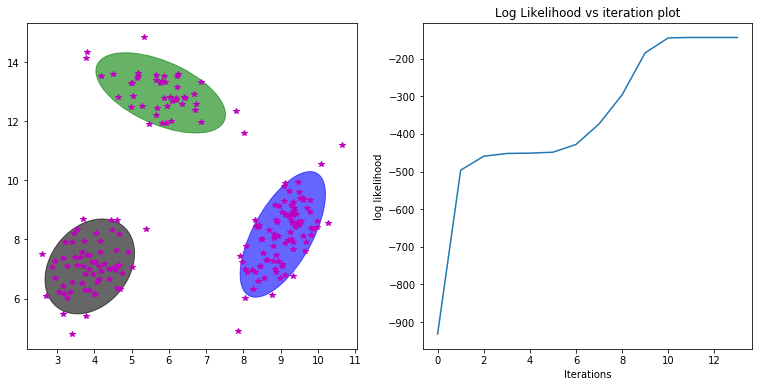

[2.20783559e-036 1.00000000e+000 1.55285737e-109]
Used default number of clusters = 3
Used default eps = 0.0001
Used default maxiters = 1000



In [2]:
import numpy as np
    
class GMM:
    
    def __init__(self, k = 3, eps = 0.0001):
        self.k = k ## number of clusters
        self.eps = eps ## threshold to stop `epsilon`
        
        # All parameters from fitting/learning are kept in a named tuple
        from collections import namedtuple
    
    def fit_EM(self, X, max_iters = 1000):
        
        # n = number of data-points, d = dimension of data points        
        n, d = X.shape
        
        # randomly choose the starting centroids/means 
        ## as 3 of the points from datasets        
        mu = X[np.random.choice(n, self.k, False), :]
        
        # initialize the covariance matrices for each gaussians
        Sigma= [np.eye(d)] * self.k
        
        # initialize the probabilities/weights for each gaussians
        w = [1./self.k] * self.k
        
        # responsibility matrix is initialized to all zeros
        # we have responsibility for each of n points for eack of k gaussians
        R = np.zeros((n, self.k))
        
        ### log_likelihoods
        log_likelihoods = []
        
        P = lambda mu, s: np.linalg.det(s) ** -.5 ** (2 * np.pi) ** (-X.shape[1]/2.) \
                * np.exp(-.5 * np.einsum('ij, ij -> i',\
                        X - mu, np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 
                        
        # Iterate till max_iters iterations        
        while len(log_likelihoods) < max_iters:
            
            # E - Step
            
            ## Vectorized implementation of e-step equation to calculate the 
            ## membership for each of k -gaussians
            for k in range(self.k):
                R[:, k] = w[k] * P(mu[k], Sigma[k])

            ### Likelihood computation
            log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
            
            log_likelihoods.append(log_likelihood)
            
            ## Normalize so that the responsibility matrix is row stochastic
            R = (R.T / np.sum(R, axis = 1)).T
            
            ## The number of datapoints belonging to each gaussian            
            N_ks = np.sum(R, axis = 0)
            
            
            # M Step
            ## calculate the new mean and covariance for each gaussian by 
            ## utilizing the new responsibilities
            for k in range(self.k):
                
                ## means
                mu[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
                x_mu = np.matrix(X - mu[k])
                
                ## covariances
                Sigma[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))
                
                ## and finally the probabilities
                w[k] = 1. / n * N_ks[k]
            # check for onvergence
            if len(log_likelihoods) < 2 : continue
            if np.abs(log_likelihood - log_likelihoods[-2]) < self.eps: break
        
        ## bind all results together
        from collections import namedtuple
        self.params = namedtuple('params', ['mu', 'Sigma', 'w', 'log_likelihoods', 'num_iters'])
        self.params.mu = mu
        self.params.Sigma = Sigma
        self.params.w = w
        self.params.log_likelihoods = log_likelihoods
        self.params.num_iters = len(log_likelihoods)       
        
        return self.params
    
    def plot_log_likelihood(self):
        import pylab as plt
        plt.plot(self.params.log_likelihoods)
        plt.title('Log Likelihood vs iteration plot')
        plt.xlabel('Iterations')
        plt.ylabel('log likelihood')
        plt.show()
    
    def predict(self, x):
        p = lambda mu, s : np.linalg.det(s) ** - 0.5 * (2 * np.pi) **\
                (-len(x)/2) * np.exp( -0.5 * np.dot(x - mu , \
                        np.dot(np.linalg.inv(s) , x - mu)))
        probs = np.array([w * p(mu, s) for mu, s, w in \
            zip(self.params.mu, self.params.Sigma, self.params.w)])
        return probs/np.sum(probs)
        
        
def demo_2d():
    
    # Load data
    #X = np.genfromtxt('data1.csv', delimiter=',')
    ### generate the random data     
    np.random.seed(3)
    m1, cov1 = [9, 8], [[.5, 1], [.25, 1]] ## first gaussian
    data1 = np.random.multivariate_normal(m1, cov1, 90)
    
    m2, cov2 = [6, 13], [[.5, -.5], [-.5, .1]] ## second gaussian
    data2 = np.random.multivariate_normal(m2, cov2, 45)
    
    m3, cov3 = [4, 7], [[0.25, 0.5], [-0.1, 0.5]] ## third gaussian
    data3 = np.random.multivariate_normal(m3, cov3, 65)
    X = np.vstack((data1,np.vstack((data2,data3))))
    np.random.shuffle(X)
#    np.savetxt('sample.csv', X, fmt = "%.4f",  delimiter = ",")
    ####
    gmm = GMM(3, 0.000001)
    params = gmm.fit_EM(X, max_iters= 100)
    print(params.log_likelihoods)
    import pylab as plt    
    from matplotlib.patches import Ellipse
    
    def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:,order]
    
        if ax is None:
            ax = plt.gca()
    
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
        # Width and height are "full" widths, not radius
        width, height = 2 * nstd * np.sqrt(abs(vals))
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
        ax.add_artist(ellip)
        return ellip    
    
    def show(X, mu, cov):

        plt.cla()
        K = len(mu) # number of clusters
        colors = ['b', 'k', 'g', 'c', 'm', 'y', 'r']
        plt.plot(X.T[0], X.T[1], 'm*')
        for k in range(K):
            plot_ellipse(mu[k], cov[k],  alpha=0.6, color = colors[k % len(colors)])  

    
    fig = plt.figure(figsize = (13, 6))
    fig.add_subplot(121)
    show(X, params.mu, params.Sigma)
    fig.add_subplot(122)
    plt.plot(np.array(params.log_likelihoods))
    plt.title('Log Likelihood vs iteration plot')
    plt.xlabel('Iterations')
    plt.ylabel('log likelihood')
    plt.show()
    print(gmm.predict(np.array([1, 2])))
       

if __name__ == "__main__":
    try:
        demo_2d()    
        from optparse import OptionParser

        parser = OptionParser()
        parser.add_option("-f", "--file", dest="filepath", help="File path for data")
        parser.add_option("-k", "--clusters", dest="clusters", help="No. of gaussians")    
        parser.add_option("-e", "--eps", dest="epsilon", help="Epsilon to stop")    
        parser.add_option("-m", "--maxiters", dest="max_iters", help="Maximum no. of iteration")        
        options, args = parser.parse_args()

        if not options.filepath : raise('File not provided')

        if not options.clusters :
            print("Used default number of clusters = 3" )
            k = 3
        else: k = int(options.clusters)

        if not options.epsilon :
            print("Used default eps = 0.0001" )
            eps = 0.0001
        else: eps = float(options.epsilon)

        if not options.max_iters :
            print("Used default maxiters = 1000" )
            max_iters = 1000
        else: eps = int(options.maxiters)

        X = np.genfromtxt(options.filepath, delimiter=',')
        gmm = GMM(k, eps)
        params = gmm.fit_EM(X, max_iters)
        print(params.log_likelihoods)
        gmm.plot_log_likelihood()
        print(gmm.predict(np.array([1, 2])))
    except:
        print("")

### Question 2

(20 points) Show why the maximization step of the Expectation Maximization in the Gaussian Mixture Model has that particular unique solution (use derivatives to prove that).

$\textbf{Solution}$<br><br>
Assumption: Data points are drawn independently from the distribution.

Gaussian Mixture distribution can be written as a linear superposition of Gaussian in the form:<br>

\begin{align}
    p(X) = \sum_{k=1}^K \pi_{k} \mathcal{N}(X|\mu_{k}, \Sigma_{k})  ------eqn(1) 
\end{align}
 where K = number of 'presumed' latent variables<br>
 $\mu_k$ = unknown mean of the $k_{th}$ latent variable<br>
 $\Sigma_k$ = unknown variance-covariance matrix of the $k_{th}$ latent variable<br>
 $\pi_k$  = mixing coefficient and must satisfy (i) $0\leq \pi_k \leq 1$ and (ii) $\displaystyle\sum_{k=1}^K$ $\pi_k$ =1<br>
    $z_k$ = the $k_{th}$ component or latent variable of the mixture distribution <br><br>
 
 We wish to estimate $\mu_k$, $\Sigma_k$, $\pi_k$ using a special form of Maximum Likelihood Estimation known as Expectation Maximization algorithm <br><br>
Let's discuss some quantities that will play an important role in the derivations with respect to the above parameters: <br>

The conditional distribution of X given a particular value for z is a Gaussian 
\begin{align}
\gamma(z_k) = p(z_k = 1|X) = \dfrac{p(X|z_k = 1)p(z_k = 1)}{p(X)}\newline
             = \dfrac{\pi_{k}\mathcal{N}(X|\mu_{k}, \Sigma_{k})}{\sum_{j=1}^K \pi_{j} \mathcal{N}(X|\mu_{j}, \Sigma_{j})} ---- eqn(2) \newline
\end{align}

The Gaussian distribution = $\mathcal{N}(X|\mu_{k}, \Sigma_{k}) = \dfrac{1}{2 \pi \Sigma_k} e^{\dfrac{-(x_n-\mu_k)^2}{2 \Sigma_k}}$ <br>
Derivative of the Gaussian distribution w.r.t $\mu_k$:
\begin{align}
-\mathcal{N}(X|\mu_{k}, \Sigma_{k}) [ \Sigma_k(x_n-\mu_k)] ---- eqn(3)
\end{align}

Let's compute the derivative of the log-likelihood of p(X) w.r.t $\mu_k$

\begin{align}
\text{Likelihood of p(X)} =  \displaystyle\prod_{i=1}^{N} \sum_{k=1}^K \pi_{k} \mathcal{N}(X|\mu_{k}, \Sigma_{k})\newline
\text{log-Likelihood of p(X)} = \text{lnp(x)} = \displaystyle\sum_{i=1}^{N} ln\displaystyle\sum_{k=1}^{K}\pi_{k} \mathcal{N}(X|\mu_{k}, \Sigma_{k}) \newline \frac{\partial lnp(x)}{\partial \mu_k}= -\displaystyle\sum_{i=1}^{N} \dfrac{\pi_k\mathcal{N}(X|\mu_{k}, \Sigma_{k}) [ \Sigma_k(x_n-\mu_k)] }{\displaystyle\sum_{k=1}^{K}\pi_{k} \mathcal{N}(X|\mu_{k}, \Sigma_{k})} =0 ---- eqn(4)\newline \text{substitute equation 2 in equation 4, then we have}\newline \displaystyle\sum_{i=1}^{N}\gamma(z_k)[ \Sigma_k(x_n-\mu_k)] = 0 ---- eqn(5)\newline \text{multiply by both sides of eqn(4) by }\Sigma_{k}^{-1} \text{ and then distribute} \newline
X_n \displaystyle\sum_{i=1}^{N}\gamma(z_k) -\mu_k \displaystyle\sum_{i=1}^{N}\gamma(z_k) = 0 \newline
\mu_k \displaystyle\sum_{i=1}^{N}\gamma(z_k) = x_n \displaystyle\sum_{i=1}^{N}\gamma(z_k) \newline
\mu_k = \dfrac{x_n \displaystyle\sum_{i=1}^{N}\gamma(z_k)}{\displaystyle\sum_{i=1}^{N}\gamma(z_k)} \newline
\text{let } N_k = \displaystyle\sum_{i=1}^{N}\gamma(z_k) --- eqn(6) \newline
\text{Therefore, } \mu_k = \dfrac{1}{N_k}\displaystyle\sum_{i=1}^{N}\gamma(z_k)X_n
\end{align}

\begin{align}
\text{log-Likelihood of p(X)} = \text{lnp(x)} = \displaystyle\sum_{i=1}^{N} ln\displaystyle\sum_{k=1}^{K}\pi_{k} \mathcal{N}(X|\mu_{k}, \Sigma_{k})\newline
\text{Derivative of the Gaussian distribution w.r.t } \Sigma_k : \newline
\frac{\partial (\mathcal{N}(X|\mu, \Sigma, \pi))}{\partial (\Sigma)} = -\mathcal{N}(X|\mu_{k}, \Sigma_{k}) [(x_n-\mu_k)^2] ---- eqn(7) \newline
\text{Let's compute the derivative of the log-likelihood of p(X) w.r.t } \Sigma_k \newline
\text{log-Likelihood of p(X)} = \text{lnp(x)} = \displaystyle\sum_{i=1}^{N} ln\displaystyle\sum_{k=1}^{K}\pi_{k} \mathcal{N}(X|\mu_{k}, \Sigma_{k}) \newline \frac{\partial lnp(x)}{\partial \mu_k} =  -\displaystyle\sum_{i=1}^{N} \dfrac{\pi_k\mathcal{N}(X|\mu_{k}, \Sigma_{k}) [(x_n-\mu_k)^2]}{\displaystyle\sum_{k=1}^{K}\pi_{k} \mathcal{N}(X|\mu_{k}, \Sigma_{k})}=0 --- eqn(8)\newline \text{substitute equation 2 in equation 8, then we have}\newline ([(x_n-\mu_k)(x_n-\mu_k)^T]-\Sigma_k)\displaystyle\sum_{i=1}^{N}\gamma(z_k) = 0 \newline \Sigma_k\displaystyle\sum_{i=1}^{N}\gamma(z_k) = [(x_n-\mu_k)(x_n-\mu_k)^T]\displaystyle\sum_{i=1}^{N}\gamma(z_k)\newline \Sigma_k = \dfrac{[(x_n-\mu_k)(x_n-\mu_k)^T]\displaystyle\sum_{i=1}^{N}\gamma(z_k)}{\displaystyle\sum_{i=1}^{N}\gamma(z_k)} --- eqn(9) \newline \text{substitute equation 2 in equation 9}\newline
\Sigma_k =  \dfrac{1}{N_k}\displaystyle\sum_{i=1}^{N}\gamma(z_k)[(x_n-\mu_k)(x_n-\mu_k)^T]
\end{align}

\begin{align}
\text{Let's compute the derivative of the log-likelihood of p(X) w.r.t } \pi_k \text{(mixing coefficients)}\newline \text{using a Lagrange multiplier and maximizing the following quantity}\newline
ln p(X|\pi, \mu, \Sigma) + \lambda \bigg(\displaystyle\sum_{i=1}^{K} \pi_k-1\bigg)\newline
\text{Under Constraint}\newline
\displaystyle\sum_{k=1}^K \pi_k = 1 \newline
\text{gives} \newline
0 = \displaystyle\sum_{i=1}^{N} \dfrac{\mathcal{N}(X_n|\mu_{k}, \Sigma_{k})}{\displaystyle\sum_{j=1}^{K}\pi_{j} \mathcal{N}(X|\mu_{j}, \Sigma_{j})} +  \lambda\newline
\text{we now multiply both sides by } \pi_k \text{ and sum over k making use of the constraint }\displaystyle\sum_{k=1}^K \pi_k = 1\newline
\text{Therefore,  }  λ = −N \newline
\text{Using this to eliminate } \lambda \text{ and rearranging we obtain  }\newline \pi_k = \dfrac{N_k}{N}
\end{align}

### Question 3

Use with a dataset different from IRIS the following techniques: (Feature importances with forests of trees)<br>
Explain why this technique is important

##### Let's preporocess the data we would use for feature importance

In [3]:
# Load the load prediction training data
filename = "train_u6lujuX_CVtuZ9i.csv"
data_loan = pd.read_csv(filename)
# Let’s list out feature-wise count of missing values
data_loan.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
# For categorical variables: imputation using mode
data_loan['Gender'].fillna(data_loan['Gender'].mode()[0], inplace=True) 
data_loan['Married'].fillna(data_loan['Married'].mode()[0], inplace=True) 
data_loan['Dependents'].fillna(data_loan['Dependents'].mode()[0], inplace=True) 
data_loan['Self_Employed'].fillna(data_loan['Self_Employed'].mode()[0], inplace=True) 
data_loan['Credit_History'].fillna(data_loan['Credit_History'].mode()[0], inplace=True)
data_loan['Credit_History'] = data_loan['Credit_History'].astype(object)
data_loan['Loan_Amount_Term'].fillna(data_loan['Loan_Amount_Term'].mode()[0], inplace=True)
data_loan['LoanAmount'].fillna(data_loan['LoanAmount'].median(), inplace=True)
data_loan.drop(['Loan_ID'], axis = 1, inplace=True)

##### Feature importances with forests of trees - Using the Loan Predictor data set

In [5]:
# Transform data to the form usable by the sklearn estimators
# Data processing - One hot encoding
data_loan_encoded =pd.get_dummies(data_loan,columns=['Gender','Married','Dependents', 
                                                     'Self_Employed','Credit_History', 'Education','Property_Area'])

In [6]:
y = data_loan_encoded["Loan_Status"]
X = data_loan_encoded.drop(['Loan_Status'], axis = 1)

In [7]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
importances = forest.feature_importances_
importances
indices=np.argsort(importances)[::-1]

In [9]:
importances

array([0.18045468, 0.11529088, 0.18015047, 0.04647208, 0.01158049,
       0.01115906, 0.00937321, 0.00938475, 0.01840975, 0.01720637,
       0.01119362, 0.01210637, 0.01316477, 0.01248699, 0.13012267,
       0.15497483, 0.01193148, 0.01220653, 0.01364182, 0.01595591,
       0.01273323])

In [10]:
print("Feature Ranking")
for f in range(X.shape[1]):
    print("%d. %s %d (%f)" % (f + 1, np.array(X.columns)[indices[f]], indices[f], 
                              importances[indices[f]]))

Feature Ranking
1. ApplicantIncome 0 (0.180455)
2. LoanAmount 2 (0.180150)
3. Credit_History_1.0 15 (0.154975)
4. Credit_History_0.0 14 (0.130123)
5. CoapplicantIncome 1 (0.115291)
6. Loan_Amount_Term 3 (0.046472)
7. Dependents_0 8 (0.018410)
8. Dependents_1 9 (0.017206)
9. Property_Area_Semiurban 19 (0.015956)
10. Property_Area_Rural 18 (0.013642)
11. Self_Employed_No 12 (0.013165)
12. Property_Area_Urban 20 (0.012733)
13. Self_Employed_Yes 13 (0.012487)
14. Education_Not Graduate 17 (0.012207)
15. Dependents_3+ 11 (0.012106)
16. Education_Graduate 16 (0.011931)
17. Gender_Female 4 (0.011580)
18. Dependents_2 10 (0.011194)
19. Gender_Male 5 (0.011159)
20. Married_Yes 7 (0.009385)
21. Married_No 6 (0.009373)


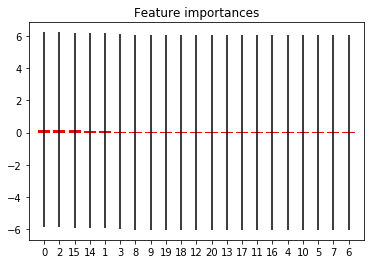

In [11]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=np.std(indices), align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

##### Why is this technique important
One motivation is to have not only an accurate model, but also an interpretable model. We want to be able to explain the output of our model by being able to indicate which features are most important in determining the obseved model result.

Knowing feature importance indicated by machine learning models can benefit you in multiple ways, for example:

* by getting a better understanding of the model’s logic you can not only verify it being correct, but also work on improving the model by focusing only on the important variables
* the above can be used for variable selection — you can remove x variables that are not that significant and have similar or better performance in much shorter training time
* in some business cases it makes sense to sacrifice some accuracy for the sake of interpretability. For example, when a bank rejects a loan application, it must also have a reasoning behind the decision, which can also be presented to the customer

### Question 4

### (10 points) Compare by discussing results the technique in 3 with the coefficients (W) of the logistic regression

In [12]:
filename = "iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
data_iris = pd.read_csv(filename, names=names)

In [13]:
X = data_iris[['sepal-length', 'sepal-width', 'petal-length', 'petal-width']]
y = (data_iris["class"]=="Iris-setosa").values.astype(int)

In [14]:
from sklearn.linear_model import LogisticRegression
clf_logit = LogisticRegression(solver='lbfgs')
clf_logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

#### We will use the SelectFromModel transformer to compare the  values of the feature_importances_ from forest of trees and the values from coef_. The SelectFromModel transformer selects features based on importance weights. The base estimator used in the SelectFromModel must have either a feature_importances_ or coef_ attribute after fitting

In [15]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(clf_logit)
sfm.fit(X, y)
#sfm.transform(X)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [16]:
# These are the features selected by the SelectFromModel transformer using the coef_ attribute of the logistic model
list(X.columns[sfm.get_support()])

['petal-length']

In [17]:
X.columns

Index(['sepal-length', 'sepal-width', 'petal-length', 'petal-width'], dtype='object')

In [18]:
np.set_printoptions(suppress=True)
clf_logit.coef_

array([[-0.44524582,  0.89469401, -2.32542777, -0.97869151]])

### Taking the absolute values of the logistic weights, we see that the most important feature is 'petal-length' which has a coefficient or weight of 2.32542777 where the negative sign depicts the direction on how it affects the response variable

#### We will repeat the above steps using forest of trees

In [19]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
sfm = SelectFromModel(forest)
sfm.fit(X, y)

SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [21]:
# These are the features selected by the SelectFromModel transformer using the feature_importances_ attribute of 
# the forest of Trees model
list(X.columns[sfm.get_support()])

['petal-length', 'petal-width']

In [22]:
X.columns

Index(['sepal-length', 'sepal-width', 'petal-length', 'petal-width'], dtype='object')

In [23]:
forest.feature_importances_

array([0.12083838, 0.07674553, 0.42121446, 0.38120163])

### Again we observe that the 2 most important features ('petal-length', 'petal-width') have the highest weights (0.42121446, 0.38120163) respectively

### Question 5

(20 points) Use the IRIS dataset and the binary classification (iris-setosa versus others). This dataset is imbalanced please
implement a technique to oversampling that will produce a balanced dataset (no duplication). (scikit)

##### Implementing Sklearn - SMOTE: Synthetic Minority Over-sampling Technique

In [24]:
print('Original dataset shape %s' % Counter(y))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

Original dataset shape Counter({0: 100, 1: 50})


In [25]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 100, 0: 100})


##### We need to confirm that there are no duplicates

In [26]:
dff=pd.DataFrame(X_res)
dff1=pd.DataFrame(X)

In [27]:
# Get the records in dff but not in dff1
(X_res[(dff.join(dff1,lsuffix='_new', rsuffix='_org')).isnull().sum(axis=1)>0]).shape

(50, 4)

In [28]:
# These are the Unique records sampled for class 1
Counter(y_res[(dff.join(dff1,lsuffix='_new', rsuffix='_org')).isnull().sum(axis=1)>0])

Counter({1: 50})

### Question 6

(10 points) Describe the main differences between K-means and DB-Scan, use examples. (scikit)

* DBSCAN does not require the user to set the number of clusters a priori but requires setting of the eps and min_samples parameters. K-means requires the number of clusters set a prior

* k-means clustering assumes that all directions are equally important for each cluster. Hence, it cannot capture clusters in some oddly shape data. DBSCAN can capture clusters of complex shapes.

* K-means include every data point in a cluster no matter how far away it is from the nearest centroid. What if some data points don't belong in any cluster? What if they are outliers or noise? The density-based spatial clustering of applications with noise (DBSCAN), addresses these situations. It does not force every data point into a cluster — if a data point lies outside of the specified starting parameters, it will be classified as "noise" and not included in any resulting cluster.

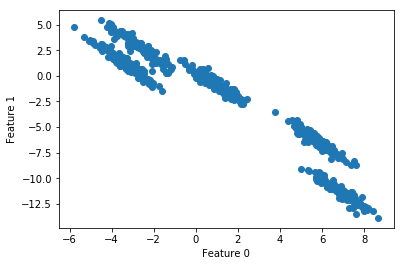

In [29]:
from sklearn.datasets import make_blobs

# generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=600, centers = 5)
rng = np.random.RandomState(74)
# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)
# plot
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

Text(0, 0.5, 'Feature 1')

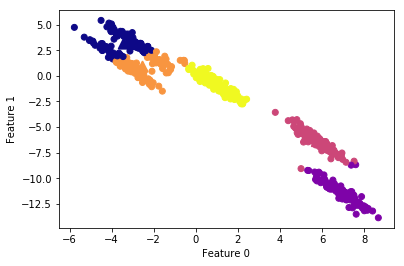

In [30]:
# Apply k-means clustering
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(X)
y_pred = kmeans.predict(X)
# plot the cluster assignments and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap="plasma")
plt.scatter(kmeans.cluster_centers_[:, 0],   
            kmeans.cluster_centers_[:, 1],
            marker='^', 
            c=[0, 1, 2, 3, 4], 
            s=100, 
            linewidth=2,
            cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

##### What we can see here is that k-means has been able to correctly detect the clusters at the middle and bottom, while presenting trouble with the clusters at the top, which are very close to each other. As k-means only considers the distance to the nearest cluster center, it can’t handle this kind of data”

##### Let’s see how DBSCAN clustering can help with this shape

Text(0, 0.5, 'Feature 1')

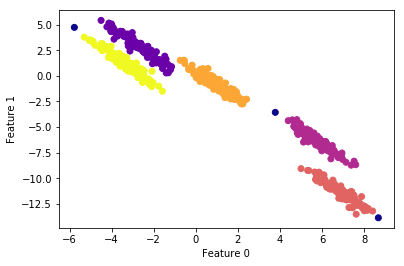

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# cluster the data into five clusters
dbscan = DBSCAN(eps=0.123, min_samples = 2)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

##### We see that DBSCAN clustering has correctly classified the data into the 5 observed clusters as well as depicted noises.

### Question 7

(10 points) Implement a procedure to estimate the optimal number of clusters in the k-Means and mixture model
(try to differentiate the two procedures). (scikit)

##### Selecting the optimal value for n_clusters(number of Clusters) with Silhouette Analysis on KMeans Clustering in Scikit-learn 
The silhouette coefficient of a data measures how well data are assigned to its own cluster and how far they are from other clusters. A silhouette close to 1 means the data points are in an appropriate cluster and a silhouette coefficient close to −1 implies out data is in the wrong cluster. 

##### Select the optimal value

      scores
2   0.728770
3   0.624657
4   0.654046
5   0.590591
6   0.543809
7   0.515957
8   0.513535
9   0.460664
10  0.478810
11  0.488412
12  0.479938
13  0.474257
14  0.473521
15  0.485091
16  0.474040
17  0.473604
18  0.483763
19  0.490789
20  0.486765
21  0.471430
22  0.475293
23  0.466348
24  0.461051
25  0.458216
26  0.440153
27  0.443877
28  0.426738
29  0.440239


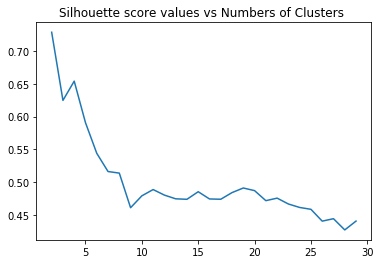

In [32]:
obs = np.concatenate( (np.random.randn(100, 2) , 20 + np.random.randn(300, 2) , -15+np.random.randn(200, 2)))
silhouette_score_values=list()
no_clust_silhouetteScore = dict()

NumberOfClusters=range(2,30)
for i in NumberOfClusters:
    classifier=cluster.KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, 
                              random_state=None, copy_x=True)
    classifier.fit(X)
    labels= classifier.predict(X)
    
    no_clust_silhouetteScore[i] = silhouette_score(X,labels ,metric='euclidean', sample_size=None, random_state=None)
    silhouette_score_values.append(silhouette_score(X,labels ,metric='euclidean', 
                                                                    sample_size=None, random_state=None))

print(pd.DataFrame.from_dict(no_clust_silhouetteScore, orient='index', columns =['scores']))
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()


In [33]:
Optimal_NumberOf_Clusters = NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of Clusters is:")
print (Optimal_NumberOf_Clusters)

Optimal number of Clusters is:
2


The number of clusters corresponds to the ground truth of the loan Prediction data set which has two classes

#### Selecting the number of components in a classical Gaussian Mixture Model

The BIC criterion can be used to select the number of components in a Gaussian Mixture in an efficient way.

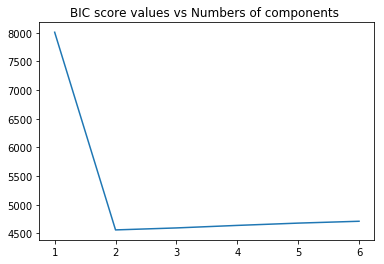

In [34]:
from sklearn.mixture import GaussianMixture 
import itertools
from scipy import linalg
import matplotlib as mpl

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)

for n_components in n_components_range:
     # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
        
# Plot the BIC scores

plt.plot(n_components_range, bic)
plt.title("BIC score values vs Numbers of components ")
plt.show()


In [35]:
Optimal_NumberOf_Clusters = n_components_range[bic.index(min(bic))]
print("Optimal number of Clusters is:")
print (Optimal_NumberOf_Clusters)

Optimal number of Clusters is:
2


### Question 8

(20 points) Implement the algorithm of hierarchical clustering with maximum or complete linkage 

##### Hierarchical Clustering - Complete linkage 

In [36]:
import math
import itertools

class Hierarchical_Clustering:
    def __init__(self, data, ipt_k):
        self.k = ipt_k # Number of Clusters
        self.dataset = data # Array to cluster
        self.heap = []
        self.cluster = []
    
    
    def euclidean_dist(self, data_point_one, data_point_two):
        """
        euclidean distance: https://en.wikipedia.org/wiki/Euclidean_distance

        assume that two data points have same dimension

        """
        return math.sqrt(sum((data_point_one - data_point_two)**2))
    
    
    def compute_pairwise_distance(self, list_data): # List of integers and tuples

        result = []

        dataset_size = len(list_data)

        for i in range(dataset_size-1):    # ignore last i

            for j in range(i+1, dataset_size): 
                if isinstance(list_data[i], int) and isinstance(list_data[j], int): 
                    dist = (self.euclidean_dist(self.dataset[list_data[i],:], self.dataset[list_data[j],:]), 
                                    (list_data[i], list_data[j]))
                else:
                    dist = self.Complete_Linkage((list_data[i], list_data[j]))
                    
                result.append(dist)
        
        return result
    
        
    def Hcluster(self):
        
        self.cluster = list(range(self.dataset.shape[0])) # Individual data points are clusters
        
        while len(self.cluster) > self.k:
            
            list_distances = min(self.compute_pairwise_distance(self.cluster))
            self.cluster.remove(list_distances[1][0])
            self.cluster.remove(list_distances[1][1])
            self.cluster.append(list_distances[1]) # Merge the most similar data points
        
        return [(clust, "class-"+ str(i)) for i, clust in enumerate(self.cluster)]
    
    def Complete_Linkage(self, pairs): #Compute Distance among pairs(between clusters) and return the max
        
        pts = []
        dist_list = []
        
        pts = self.checkio(pairs)
  
        for i in range(len(pts) - 1):
            for j in range(i+1, len(pts)):
                dist_list.append((self.euclidean_dist(self.dataset[pts[i],:], self.dataset[pts[j],:]), pairs))
  
        return max(dist_list)
    
    def checkio(self, *args):
        result = []
        for value in args:
            if isinstance(value, tuple):
                result += self.checkio(*value)
            else:
                result.append(value)
        return tuple(result)

In [37]:
# Instantiate the Hierarchical_Clustering class with a small dataset
cluster = Hierarchical_Clustering(X[0:10,:],3)

In [38]:
# Cluster the dataset
cluster.Hcluster()

[((2, 9), 'class-0'),
 (((3, 8), (6, (4, (0, 7)))), 'class-1'),
 ((1, 5), 'class-2')]